<center><h2> Walmart Sales Forecasting </h2></center>

### Problem Statemtent

<b> By using these data we have to Predict the walmart sales forecasting based on different parameters</b>

### Data Description

stores.csv

    This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv

    This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week
    test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

features.csv

    This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

### Business objectives and constraints

1. The cost of a mis-classification can be very high.
2. There is some latency concerns.


### Importing Libraries

In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

### Reading the Data From the CSV file

In [55]:
train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
test_df = pd.read_csv('test.csv')

<ipython-input-55-63f26dd202f7>:1: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [56]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [57]:
train_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [58]:
train_df.shape

(207323, 5)

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207323 entries, 0 to 207322
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         207323 non-null  int64  
 1   Dept          207323 non-null  int64  
 2   Date          207323 non-null  object 
 3   Weekly_Sales  207323 non-null  float64
 4   IsHoliday     207322 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 7.9+ MB


In [60]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,207323.000000,207323.000000,207323.000000
mean,11.030030,43.574278,17687.247272
std,6.069809,29.743694,25112.020937
min,1.000000,1.000000,-1699.000000
25%,6.000000,19.000000,2735.035000
50%,11.000000,36.000000,8446.260000
75%,16.000000,71.000000,21732.945000
max,22.000000,99.000000,693099.360000


In [61]:
train_df.isnull()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
207318,False,False,False,False,False
207319,False,False,False,False,False
207320,False,False,False,False,False
207321,False,False,False,False,False


In [62]:
train_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       1
dtype: int64

In [63]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [64]:
features_df.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [65]:
features_df.shape

(8190, 12)

In [66]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [67]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [68]:
features_df.isnull()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,False,False,False,False,True,True,True,True,True,False,False,False
1,False,False,False,False,True,True,True,True,True,False,False,False
2,False,False,False,False,True,True,True,True,True,False,False,False
3,False,False,False,False,True,True,True,True,True,False,False,False
4,False,False,False,False,True,True,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,False,False,False,False,False,False,False,False,False,True,True,False
8186,False,False,False,False,False,False,False,False,False,True,True,False
8187,False,False,False,False,False,False,False,False,False,True,True,False
8188,False,False,False,False,False,False,False,False,False,True,True,False


In [69]:
features_df.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [70]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [71]:
stores_df.columns

Index(['Store', 'Type', 'Size'], dtype='object')

In [72]:
stores_df.shape

(45, 3)

In [73]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [74]:
stores_df.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [75]:
stores_df.isnull()

,Store,Type,Size
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


In [76]:
stores_df.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

Visualizing the Type of the Stores along with their percentage

In [77]:
labels = stores_df["Type"].value_counts()[:10].index
values = stores_df["Type"].value_counts()[:10].values

colors=stores_df["Type"]

fig = go.Figure(data=[go.Pie(labels = labels, values=values, textinfo="label+percent", marker=dict(colors=colors))])

fig.show()

Type A has the max number of store

Since features and stores have 'Store' as a common column lets merge the data

In [78]:
# Using the merge function to merge ans we are merging along the common column named Store
dataset = features_df.merge(stores_df, how='inner', on='Store')
dataset.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [79]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [80]:
# Total number of columns in the dataset
dataset.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size'],
      dtype='object')

In [81]:
# Getting the info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


since the Date in the above dataset is string value we can convert them into datetime using the datetime

In [82]:
# Describing the dataset
dataset.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000,8190.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821,130287.600000
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259,63115.971429
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.000000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000,70713.000000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000,126512.000000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000,202307.000000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000


Visualizing the Type of the Stores along with their percentage in the dataset

In [83]:
labels = dataset["Type"].value_counts()[:10].index  # Taking the top 10 index
values = dataset["Type"].value_counts()[:10].values  # Taking the top 10 values

colors=dataset["Type"]

fig = go.Figure(data=[go.Pie(labels = labels, values=values, textinfo="label+percent", marker=dict(colors=colors))])

fig.show()

Type A has the maximum number of stores

lets get the datatype info of the test dataset

Here Date is of string type

In [84]:
# Getting the info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


Here also Date is of string type

Visualizing the top 10 Department in the train dataset along with their percentage

In [85]:
labels = train_df["Dept"].value_counts()[:10].index  # Taking the top 10 index
values = train_df["Dept"].value_counts()[:10].values  # Taking the top 10 values

colors=train_df["Dept"]

fig = go.Figure(data=[go.Pie(labels = labels, values=values, textinfo="label+percent", marker=dict(colors=colors))])

fig.show()

Visualizing the top 10 store in the train dataset along with their percentage

Visualizing the Store Data

In [86]:
labels = train_df["Store"].value_counts()[:10].index  # Taking the top 10 index
values = train_df["Store"].value_counts()[:10].values  # Taking the top 10 values

colors=train_df["Store"]

fig = go.Figure(data=[go.Pie(labels = labels, values=values, textinfo="label+percent", marker=dict(colors=colors))])

fig.show()

Visualizing the IsHoliday Data

In [87]:
labels = train_df['IsHoliday'].value_counts().index # Taking the all index
values = train_df['IsHoliday'].value_counts().values  # Taking the all values

colors=train_df['IsHoliday']

fig = go.Figure(data=[go.Pie(labels = labels, values=values, textinfo="label+percent", marker=dict(colors=colors))])

fig.show()

As per the plot for the 93% of the time there is no Holiday

In [88]:
# Total number of columns in the test_df
test_df.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

In [89]:
# To know more about the test_df
test_df.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [90]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207323 entries, 0 to 207322
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         207323 non-null  int64  
 1   Dept          207323 non-null  int64  
 2   Date          207323 non-null  object 
 3   Weekly_Sales  207323 non-null  float64
 4   IsHoliday     207322 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 7.9+ MB


In [91]:
from datetime import datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207323 entries, 0 to 207322
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         207323 non-null  int64         
 1   Dept          207323 non-null  int64         
 2   Date          207323 non-null  datetime64[ns]
 3   Weekly_Sales  207323 non-null  float64       
 4   IsHoliday     207322 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.9+ MB


In [93]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
 12  Type          8190 non-null   object        
 13  Size          8190 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 839.9+ KB


In [94]:
dataset['Week'] = dataset.Date.dt.isocalendar().week
dataset['Year'] = dataset.Date.dt.year


In [95]:
dataset.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,9,2010


In [96]:
# Merging with train_df

train_merge = train_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [97]:
# Merging with test_df

test_merge = test_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [98]:
def scatter(train_merge, column):
    plt.figure()
    plt.scatter(train_merge[column] , train_merge['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

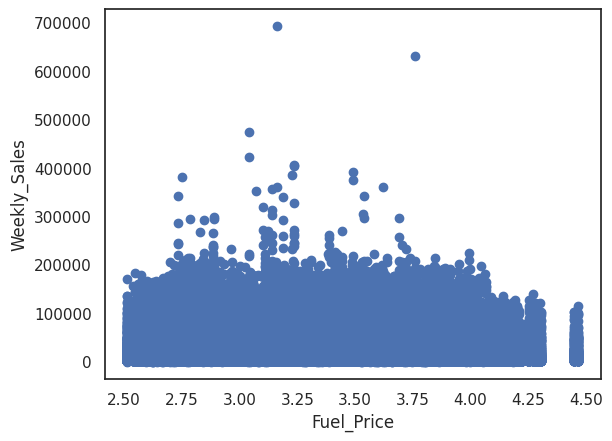

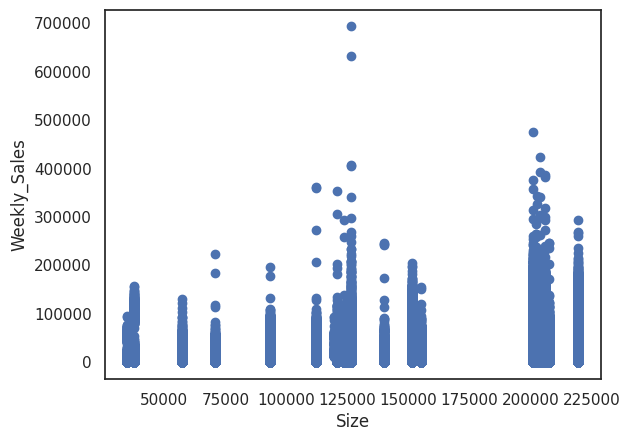

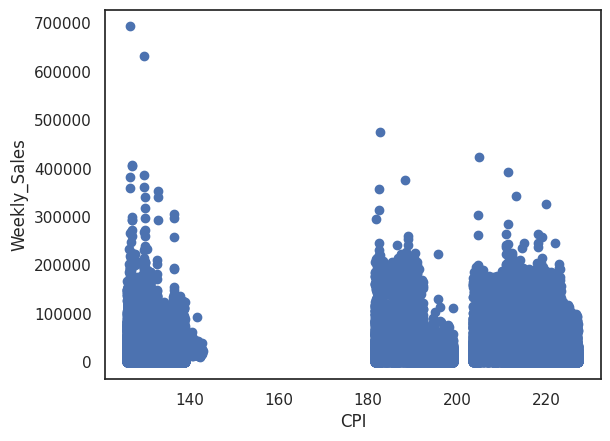

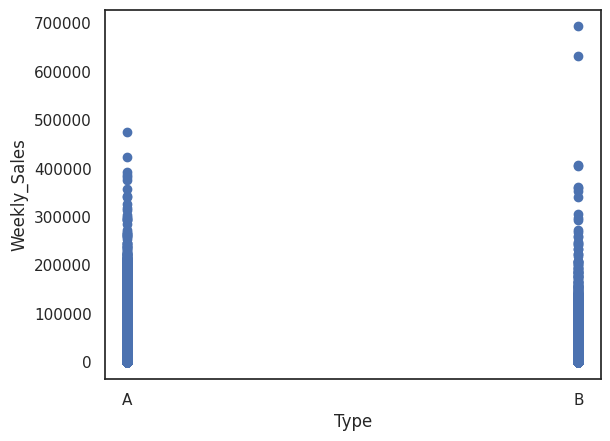

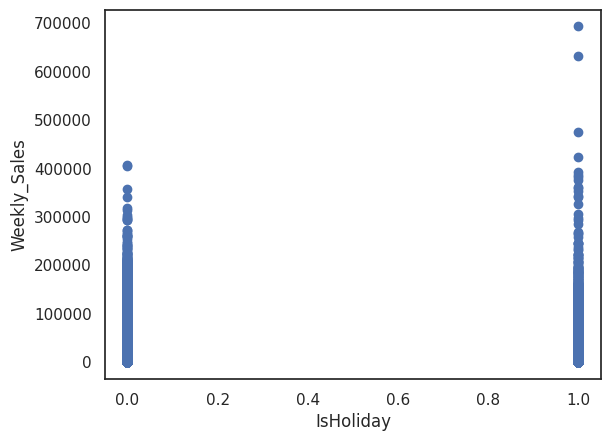

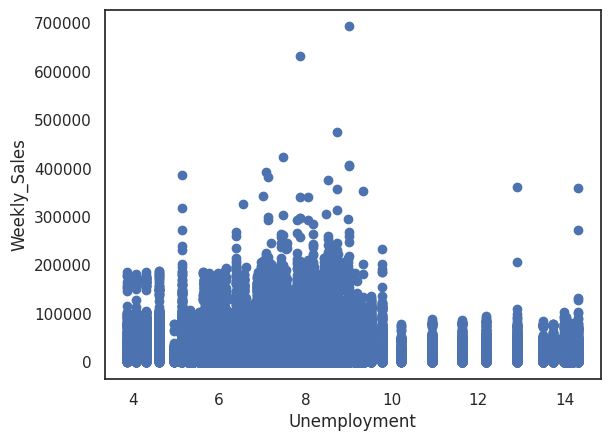

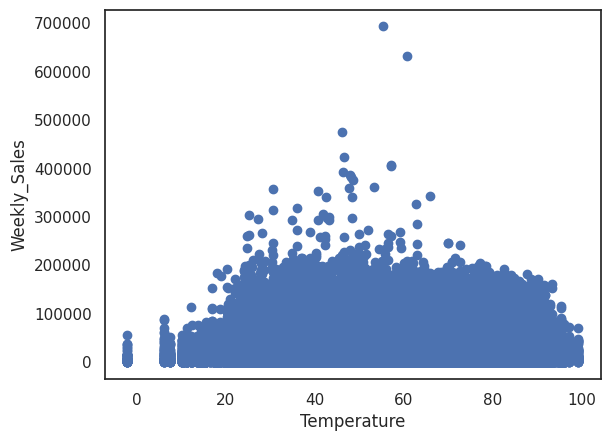

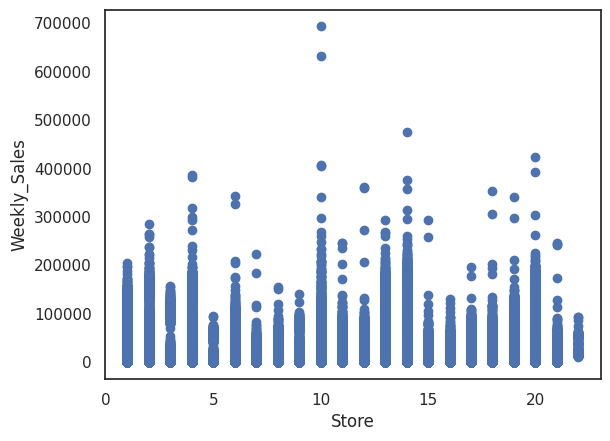

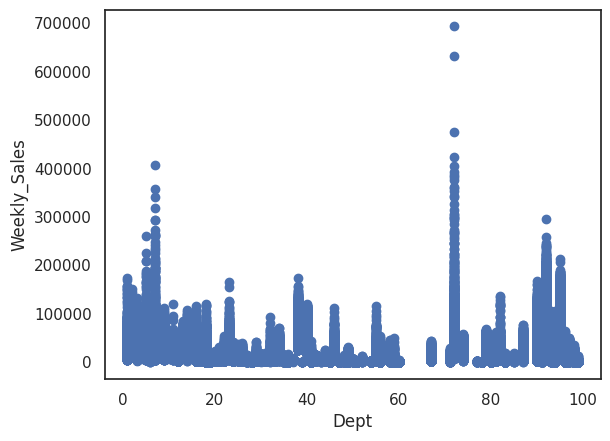

In [99]:
scatter(train_merge, 'Fuel_Price')  # with respect to Fuel_Price
scatter(train_merge, 'Size')  # with respect to Size
scatter(train_merge, 'CPI')  # with respect to CPI
scatter(train_merge, 'Type')  # with respect to Type
scatter(train_merge, 'IsHoliday') # with respect to IsHoliday
scatter(train_merge, 'Unemployment')  # with respect to Unemployment
scatter(train_merge, 'Temperature') # with respect to Temperature
scatter(train_merge, 'Store') # with respect to Store
scatter(train_merge, 'Dept')  # with respect to Dept

Let's have a look at the Average Weekly Sales per Year and find out if there is any other holiday peak sales that were not considered by 'IsHoliday' filed

<Axes: xlabel='Week'>

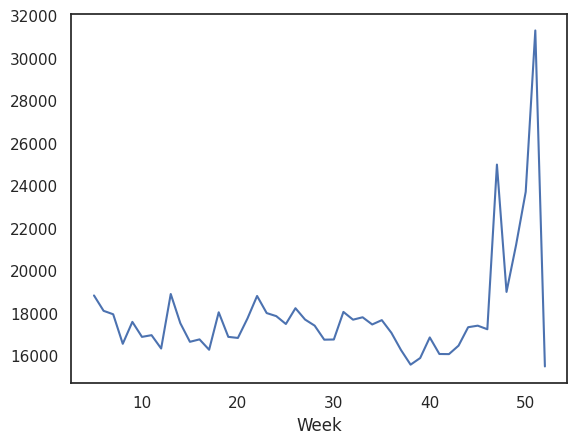

In [100]:
# Average Weekly Sales for the year 2010
weekly_sales_2010 = train_merge[train_merge['Year']==2010]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
 # for plotting then lineplot

<Axes: xlabel='Week'>

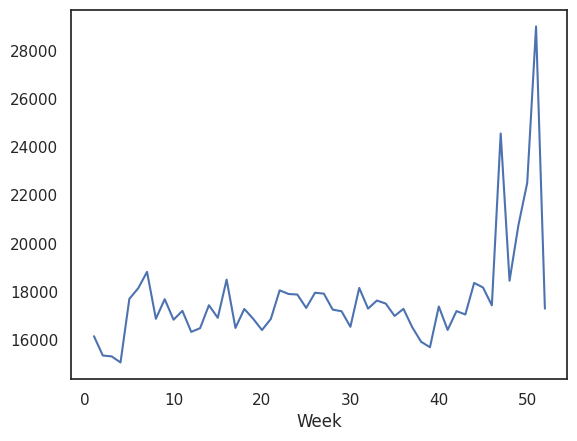

In [101]:
# Average Weekly Sales for the year 2011
weekly_sales_2011 = train_merge[train_merge['Year']==2011]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
 # for plotting then lineplot

<Axes: xlabel='Week'>

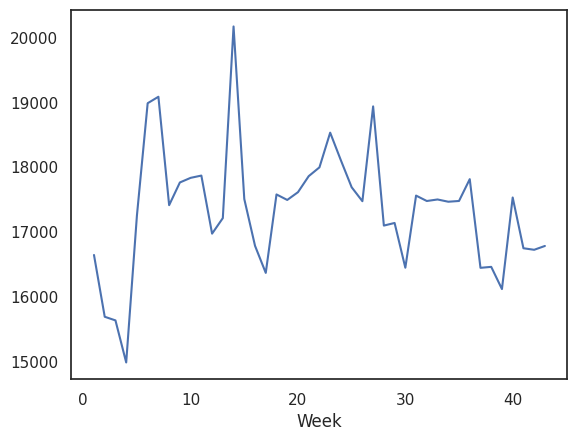

In [102]:
# Average Weekly Sales for the year 2012
weekly_sales_2012 = train_merge[train_merge['Year']==2012]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
 # for plotting then lineplot

<Figure size 2000x800 with 0 Axes>

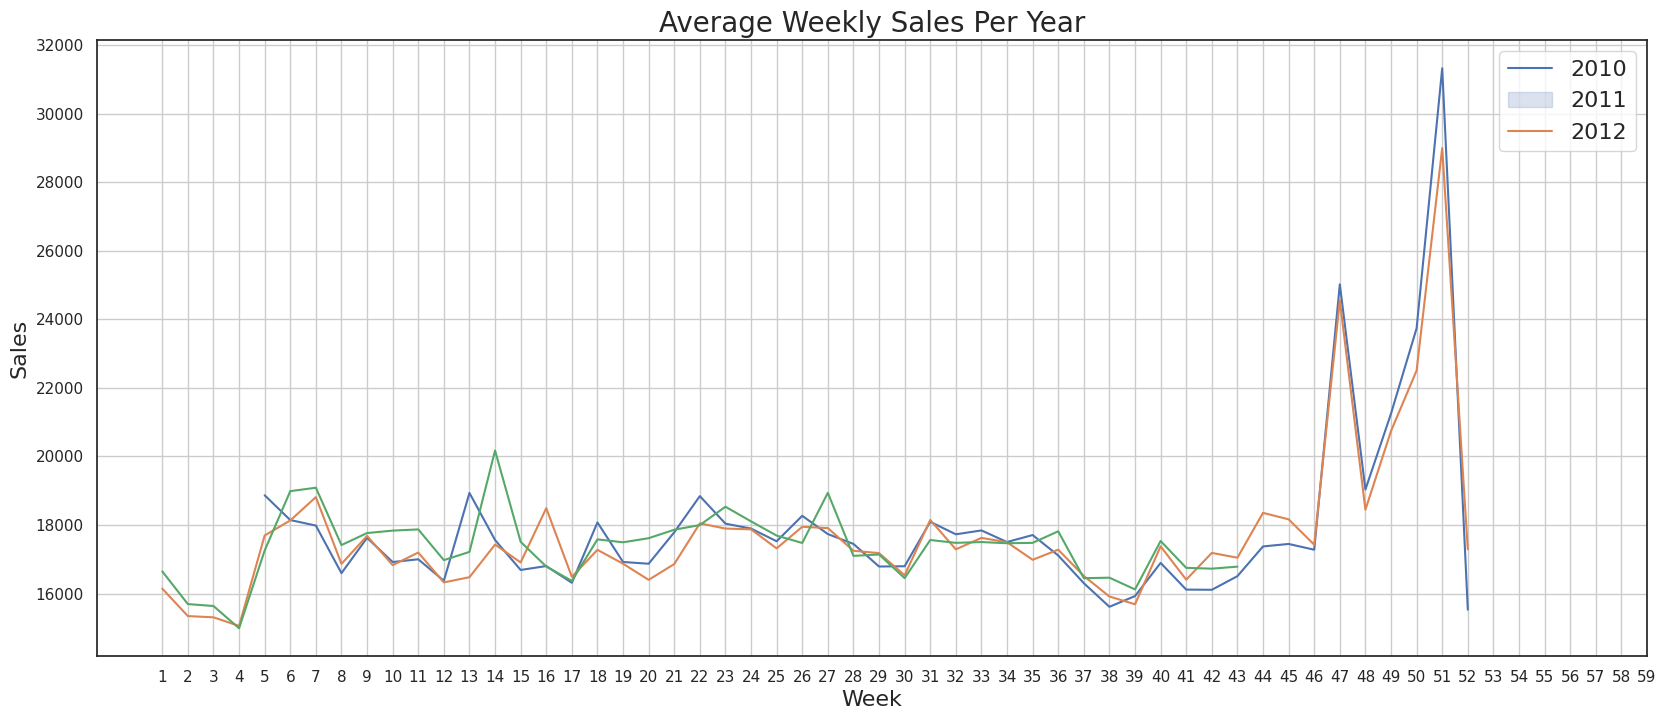

In [103]:
# Plotting the above three plot together
plt.figure(figsize=(20,8))
plt.figure(figsize=(20, 8))
sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1,60, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales Per Year', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

<ipython-input-104-1f51baac7870>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




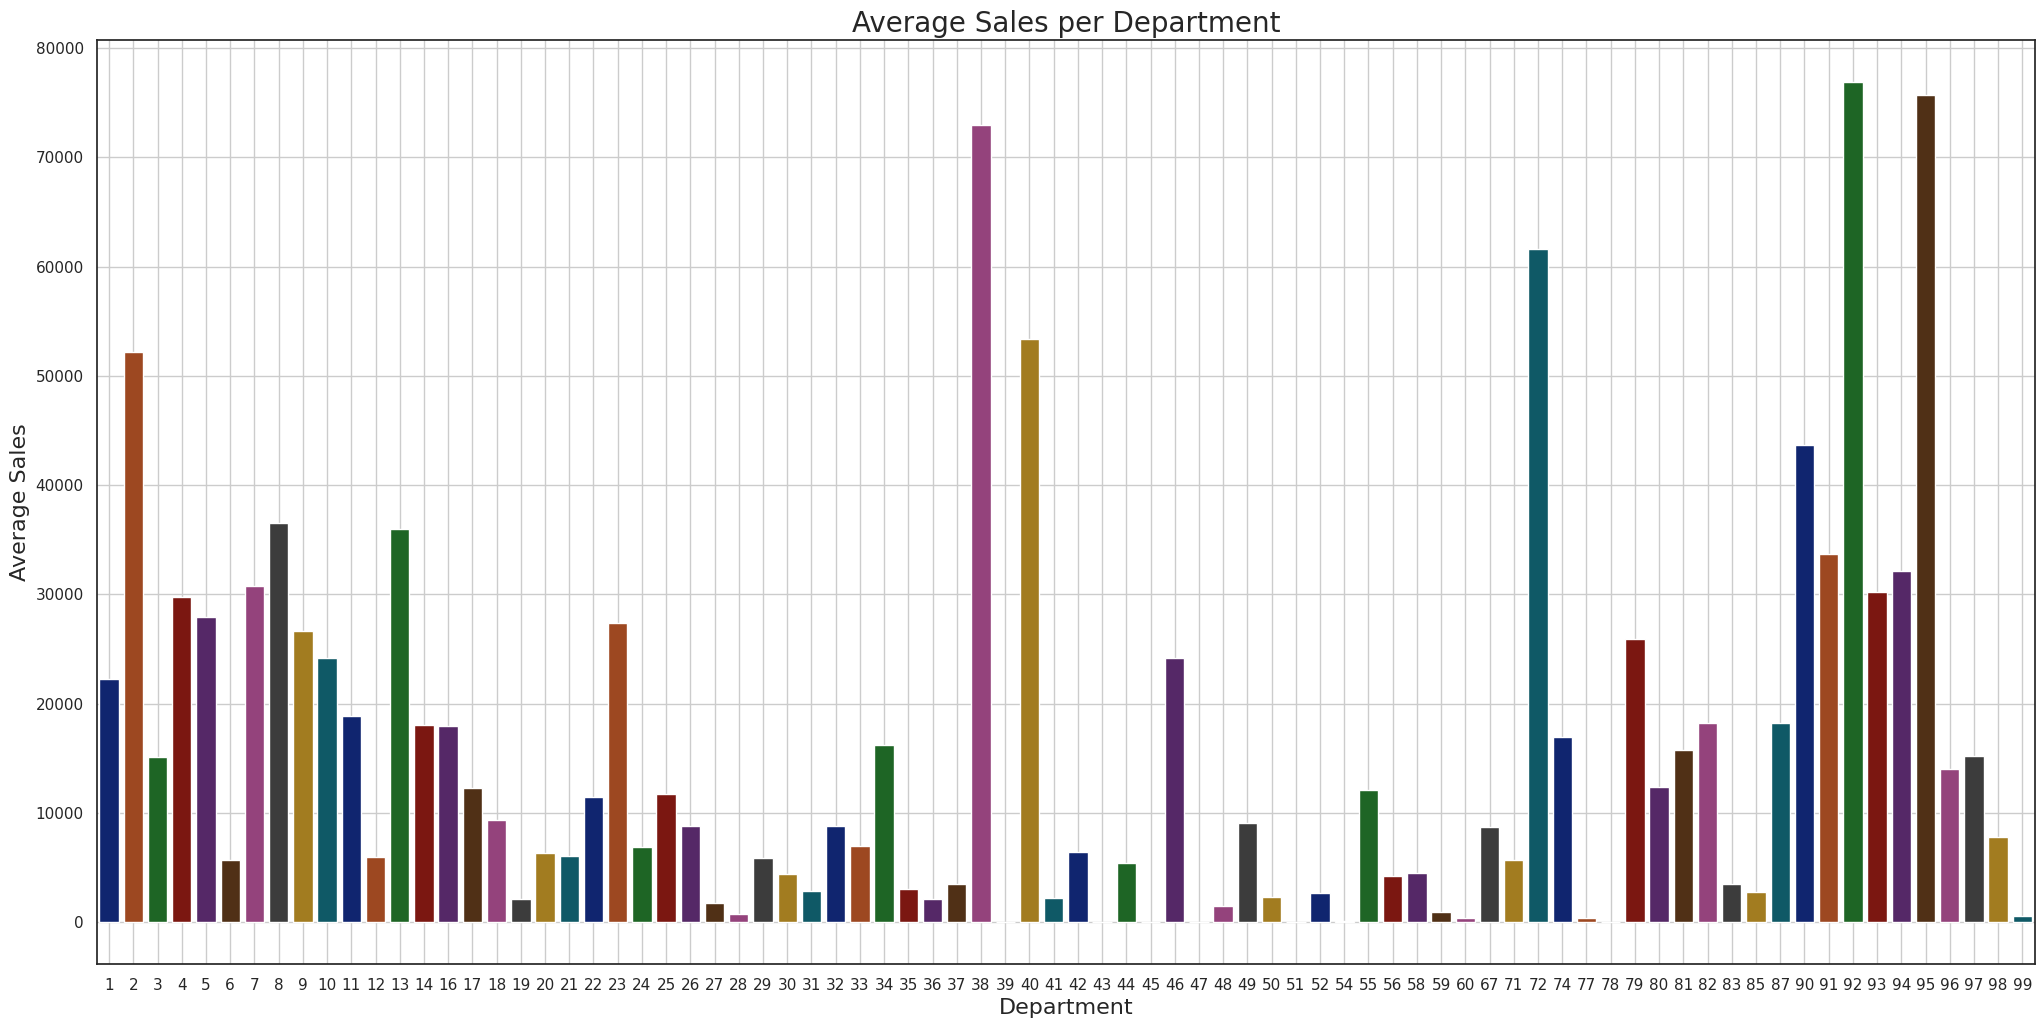

In [104]:
# Calculate average sales per department
weekly_sales = train_merge['Weekly_Sales'].groupby(train_merge['Dept']).mean()

# Plotting average sales per department
plt.figure(figsize=(25, 12))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales per Department', fontsize=20)
plt.xlabel('Department', fontsize=16)
plt.ylabel('Average Sales', fontsize=16)
plt.show()

<ipython-input-105-22e6c6c29cef>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




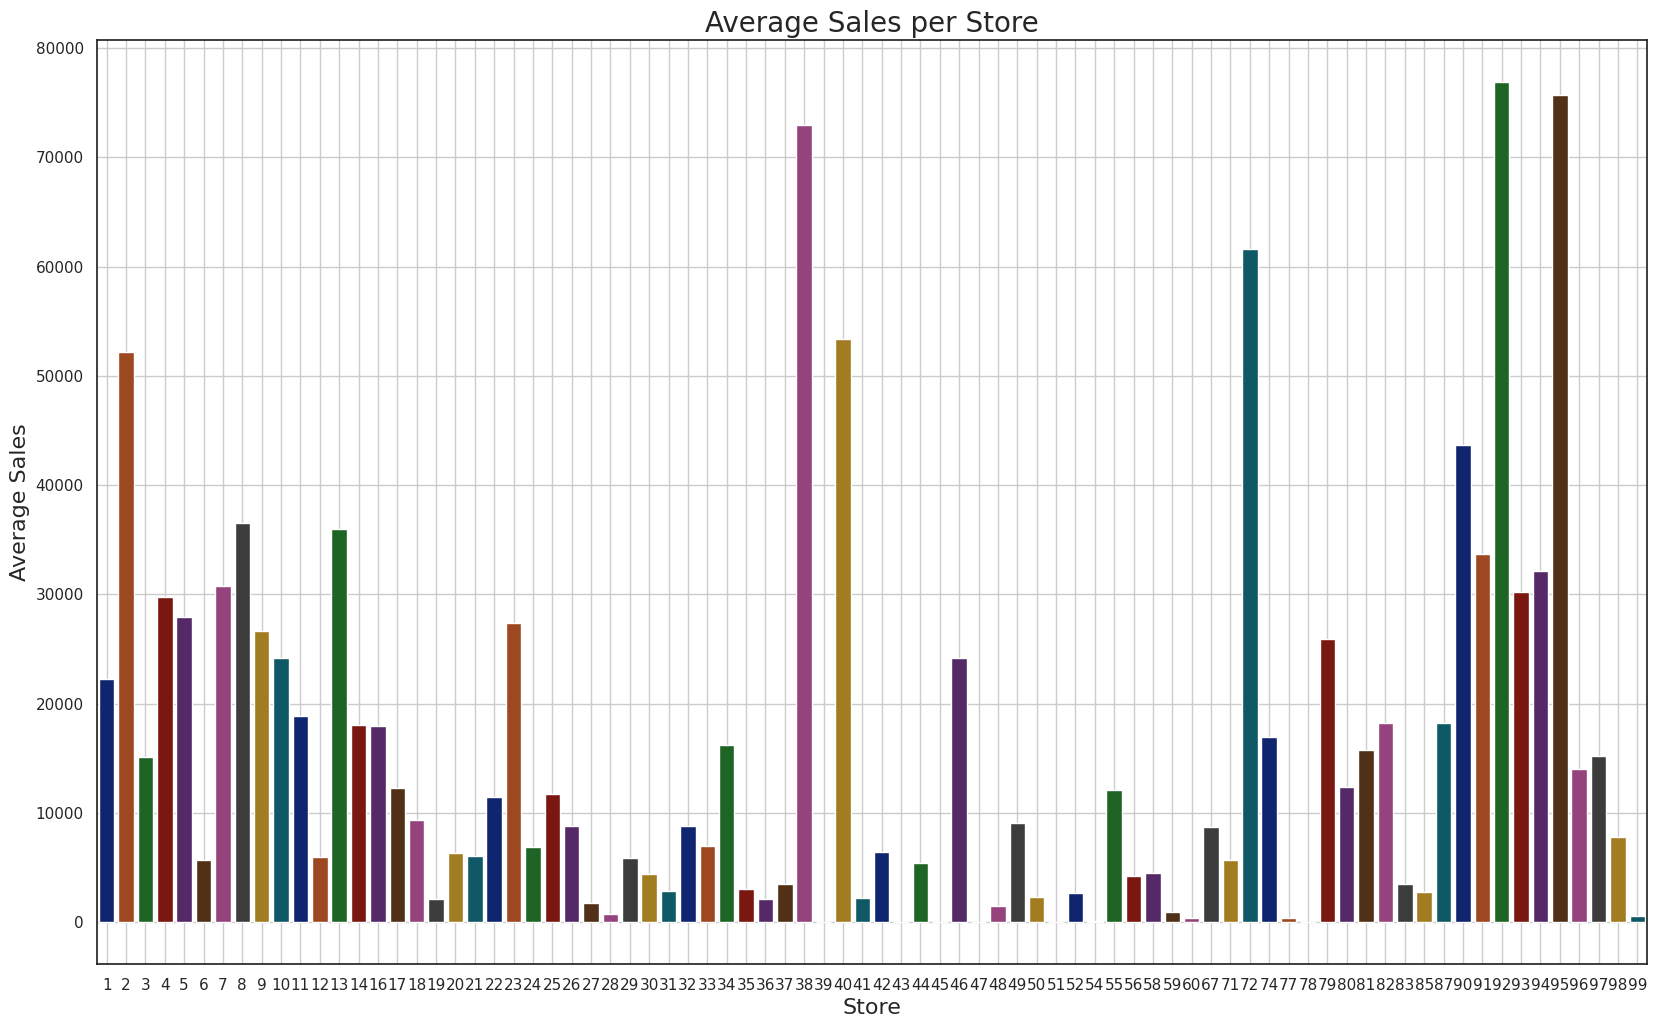

In [105]:
plt.figure(figsize=(20, 12))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales per Store', fontsize=20)
plt.xlabel('Store', fontsize=16)
plt.ylabel('Average Sales', fontsize=16)
plt.show()


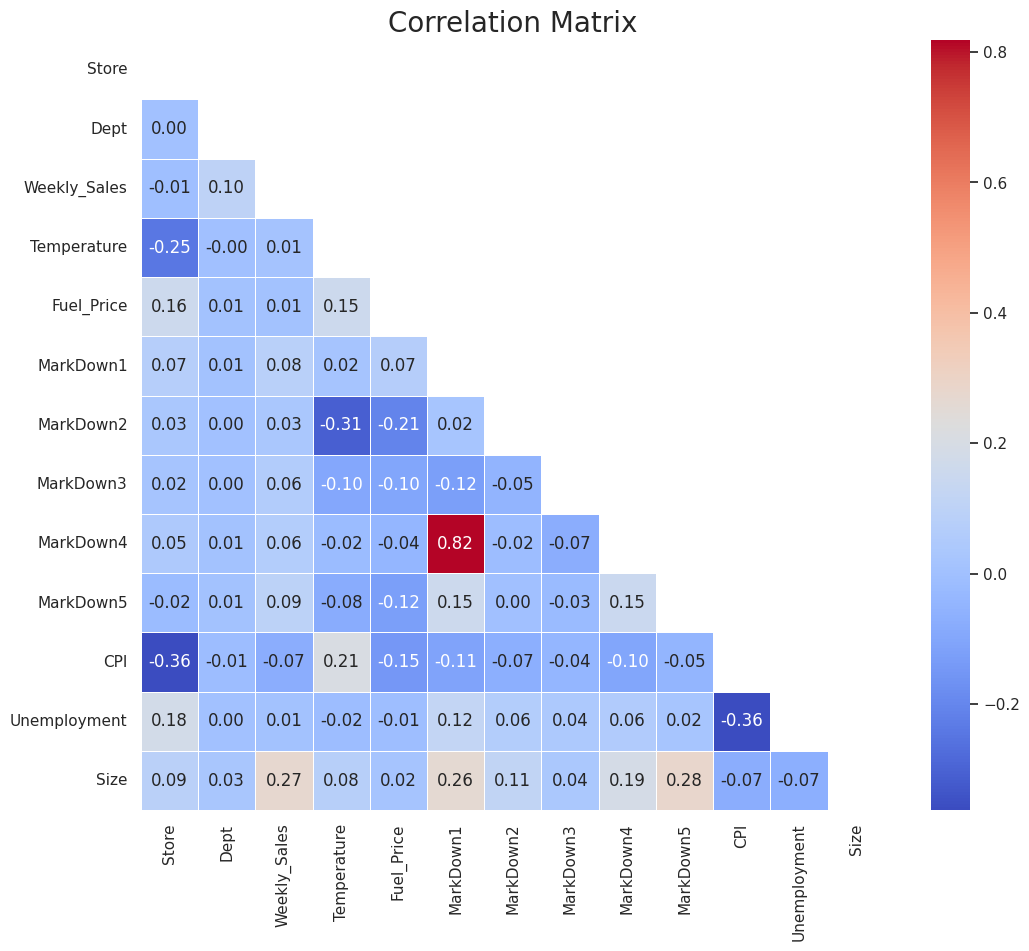

In [109]:
sns.set(style="white")

# Selecting only numeric columns for correlation calculation
numeric_columns = train_merge.select_dtypes(include=['float64', 'int64'])

# Calculating correlation matrix
corr = numeric_columns.corr()

# Creating a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # Use 'bool' instead of 'np.bool'

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=20)
plt.show()


In [110]:
# Dropping down the variables that have weak correlation

train_merge = train_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
test_merge = test_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

In [111]:
train_merge.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,211.350143,8.106,A,151315,9,2010


In [112]:
test_merge.head()

,Store,Dept,Date,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2012-11-02,False,55.32,223.462779,6.573,A,151315,44,2012
1,1,1,2012-11-09,False,61.24,223.481307,6.573,A,151315,45,2012
2,1,1,2012-11-16,False,52.92,223.512911,6.573,A,151315,46,2012
3,1,1,2012-11-23,True,56.23,223.561947,6.573,A,151315,47,2012
4,1,1,2012-11-30,False,52.34,223.610984,6.573,A,151315,48,2012


In [113]:
# Counting the number of unique values
train_df['Dept'].nunique()

80

In [114]:
# Counting the number of unique values
train_df['Store'].nunique()

22

In [115]:
# Getting the columns in the train_merge
train_merge.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'CPI', 'Unemployment', 'Type', 'Size', 'Week', 'Year'],
      dtype='object')

In [116]:
# Getting the columns in test_merge
test_merge.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'CPI',
       'Unemployment', 'Type', 'Size', 'Week', 'Year'],
      dtype='object')

### Dividing the data into Train and Test

In [117]:
X = train_merge[['Store','Dept','IsHoliday','Size','Week','Year']] # Selecting the values to be taken in the X
y = train_merge['Weekly_Sales']

# Model Building

In [118]:
# Splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145125 entries, 142577 to 121958
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      145125 non-null  int64 
 1   Dept       145125 non-null  int64 
 2   IsHoliday  145125 non-null  object
 3   Size       145125 non-null  int64 
 4   Week       145125 non-null  UInt32
 5   Year       145125 non-null  int32 
dtypes: UInt32(1), int32(1), int64(3), object(1)
memory usage: 6.8+ MB


In [120]:
# Performing GridSearchCV on Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

depth = list(range(3,30))
param_grid = dict(max_depth = depth)
tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
tree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [121]:
# Predicting train and test results
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [122]:
print("Train Results for Decision Tree Regressor Model:")
print("Root Mean squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
Root Mean squared Error:  1594.5126239332442
R-Squared:  0.9960021503839392


In [123]:
print("Test Results for Decision Tree Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
Root Mean Squared Error:  5164.653780284027
R-Squared:  0.9568458182416361


In [124]:
# Performing RandomsearchCV on Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
tuned_params = {'n_estimators': [100, 200], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 3, scoring = 'neg_mean_absolute_error', cv = 3, n_jobs = -1)
random_regressor.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   scoring='neg_mean_absolute_error')

In [125]:
# Predicting train and test results
y_train_pred = random_regressor.predict(X_train)
y_test_pred = random_regressor.predict(X_test)

In [126]:
print("Train Results for Random Forest Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Random Forest Regressor Model:
Root Mean Squared Error:  2254.3921664130494
R-Squared:  0.9920084786686921


In [127]:
print("Test Results for Random Forest Regressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(y_test, y_test_pred)))
print("R-Squared: ", r2_score(y_test, y_test_pred))

Test Results for Random Forest Regressor Model:
Root Mean Squared Error:  4249.850711719637
R-Squared:  0.9707794888470784


**Conclusion**
With the above implementation it was possible to forecast the prediction for the Walmart Stores